In [5]:
!pip install xgboost

   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   -- ------------------------------------- 2.9/56.8 MB 16.7 MB/s eta 0:00:04
   ---- ----------------------------------- 6.6/56.8 MB 17.5 MB/s eta 0:00:03
   ------- -------------------------------- 10.0/56.8 MB 17.2 MB/s eta 0:00:03
   --------- ------------------------------ 13.4/56.8 MB 17.1 MB/s eta 0:00:03
   ----------- ---------------------------- 15.7/56.8 MB 16.0 MB/s eta 0:00:03
   ------------ --------------------------- 17.3/56.8 MB 14.7 MB/s eta 0:00:03
   ------------ --------------------------- 17.8/56.8 MB 13.1 MB/s eta 0:00:03
   ------------ --------------------------- 18.4/56.8 MB 11.7 MB/s eta 0:00:04
   ------------- -------------------------- 18.9/56.8 MB 10.5 MB/s eta 0:00:04
   ------------- -------------------------- 19.4/56.8 MB 9.7 MB/s eta 0:00:04
   -------------- ------------------------- 19.9/56.8 MB 9.1 MB/s eta 0:00:05
   -------------- ------------------------- 20.4/56.8 MB 8.3 MB/s

In [6]:
import os
import cv2
import numpy as np
from skimage import feature
import random
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

# XAI Libraries
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

%matplotlib inline

os.environ['KMP_DUPLICATE_LIB_OK']='True'

C:\Users\Reach\anaconda3\envs\pytorch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# (Cell for quantify_image and load_split functions - no changes)
def quantify_image(image):
    features = feature.hog(image, orientations=9,
                           pixels_per_cell=(10, 10), cells_per_block=(2, 2),
                           transform_sqrt=True, block_norm="L1")
    return features

def load_split(path):
    imagePaths = list(paths.list_images(path))
    data = []
    labels = []
    for imagePath in imagePaths:
        label = imagePath.split(os.path.sep)[-2]
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        image = cv2.threshold(image, 0, 255,
                              cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        features = quantify_image(image)
        data.append(features)
        labels.append(label)
    return (np.array(data), np.array(labels))

In [13]:
# Corrected train_models function
def train_models(dataset):
    models = {
        "Rf": {"classifier": RandomForestClassifier(random_state=1), "accuracy": 0, "sensitivity": 0, "specificity": 0},
        "Xgb": {"classifier": XGBClassifier(), "accuracy": 0, "sensitivity": 0, "specificity": 0}
    }

    # -- FIX: Use relative paths for local execution --
    trainingPath = os.path.join(dataset, "training")
    testingPath = os.path.join(dataset, "testing")
    
    # Check if paths exist to help with debugging
    if not os.path.exists(trainingPath):
        print(f"ERROR: Training path not found at: {trainingPath}")
        return None
    if not os.path.exists(testingPath):
        print(f"ERROR: Testing path not found at: {testingPath}")
        return None

    (trainX, trainY) = load_split(trainingPath)
    (testX, testY) = load_split(testingPath)

    # If no data is loaded, exit gracefully
    if len(trainX) == 0:
        print(f"ERROR: No training images found in {trainingPath}")
        return None

    le = LabelEncoder()
    trainY = le.fit_transform(trainY)
    testY = le.transform(testY)

    for model in models:
        models[model]["classifier"].fit(trainX, trainY)
        predictions = models[model]["classifier"].predict(testX)
        cm = confusion_matrix(testY, predictions).ravel()
        
        # Handle cases where a class is not predicted, to avoid errors
        if len(cm) == 4:
            tn, fp, fn, tp = cm
            models[model]["accuracy"] = (tp + tn) / float(cm.sum())
            models[model]["sensitivity"] = tp / float(tp + fn) if (tp + fn) > 0 else 0.0
            models[model]["specificity"] = tn / float(tn + fp) if (tn + fp) > 0 else 0.0
    return models

# Now, call the function with the correct relative paths from your project's root directory
spiralModels = train_models('Dataset/spiral')
waveModels = train_models('Dataset/wave')

In [14]:
print("Random Forest vs XGBoost Classifier (Spiral Drawings)\n")
for metric in ("accuracy", "sensitivity", "specificity"):
    print(f"{metric.capitalize()}: ")
    print("Random Forest={:.2f}%, XGBoost={:.2f}% \n".format(
        spiralModels['Rf'][metric]*100, spiralModels['Xgb'][metric]*100))

Random Forest vs XGBoost Classifier (Spiral Drawings)

Accuracy: 
Random Forest=86.67%, XGBoost=73.33% 

Sensitivity: 
Random Forest=80.00%, XGBoost=73.33% 

Specificity: 
Random Forest=93.33%, XGBoost=73.33% 



In [15]:
print("\nRandom Forest vs XGBoost Classifier (Wave Drawings)\n")
for metric in ("accuracy", "sensitivity", "specificity"):
    print(f"{metric.capitalize()}: ")
    print("Random Forest={:.2f}%, XGBoost={:.2f}% \n".format(
        waveModels['Rf'][metric]*100, waveModels['Xgb'][metric]*100))


Random Forest vs XGBoost Classifier (Wave Drawings)

Accuracy: 
Random Forest=76.67%, XGBoost=73.33% 

Sensitivity: 
Random Forest=73.33%, XGBoost=80.00% 

Specificity: 
Random Forest=80.00%, XGBoost=66.67% 



Spiral Image Predictions:


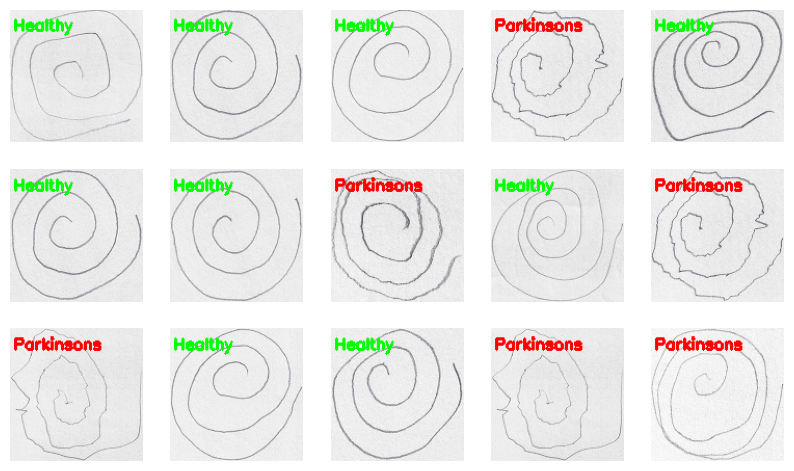


Wave Image Predictions:


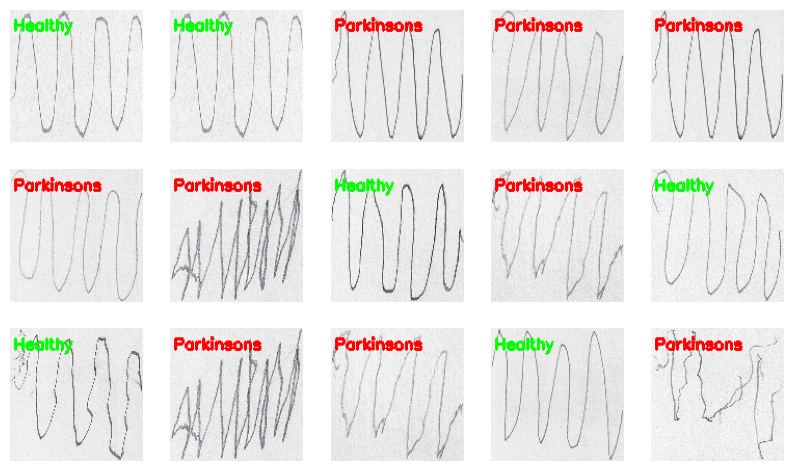

In [18]:
def test_prediction(model, testingPath):
    """
    Tests the model on random images and visualizes the predictions.
    """
    # This line lists all images in the provided path
    testingPaths = list(paths.list_images(testingPath))

    # Add a check to ensure images were found
    if not testingPaths:
        print(f"ERROR: No images found in the directory: {testingPath}")
        return

    output_images = []

    # Loop through a few random images for prediction
    for _ in range(min(15, len(testingPaths))): # Avoids error if less than 15 images
        image_path = random.choice(testingPaths)
        image = cv2.imread(image_path)
        
        # Ensure the image loaded correctly
        if image is None:
            continue

        output = image.copy()
        output = cv2.resize(output, (128, 128))
        
        # Preprocess for the model
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray_image = cv2.resize(gray_image, (200, 200))
        _, threshold_image = cv2.threshold(gray_image, 0, 255,
                                           cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

        features = quantify_image(threshold_image)
        preds = model.predict([features])
        label = "Parkinsons" if preds[0] else "Healthy"

        color = (0, 0, 255) if label == "Parkinsons" else (0, 255, 0)
        cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        output_images.append(output)

    # Display the images
    plt.figure(figsize=(10, 10))
    for i in range(len(output_images)):
        plt.subplot(5, 5, i + 1)
        # Convert BGR (from OpenCV) to RGB (for Matplotlib)
        plt.imshow(cv2.cvtColor(output_images[i], cv2.COLOR_BGR2RGB))
        plt.axis("off")
    plt.show()


# **FIX:** Corrected the paths to be relative for local execution
if spiralModels:
    print("Spiral Image Predictions:")
    test_prediction(spiralModels['Rf']['classifier'], 'Dataset/spiral/testing')

if waveModels:
    print("\nWave Image Predictions:")
    test_prediction(waveModels['Xgb']['classifier'], 'Dataset/wave/testing')

--- LIME Explanations for Spiral Drawings (Random Forest Model) ---


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.41it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].


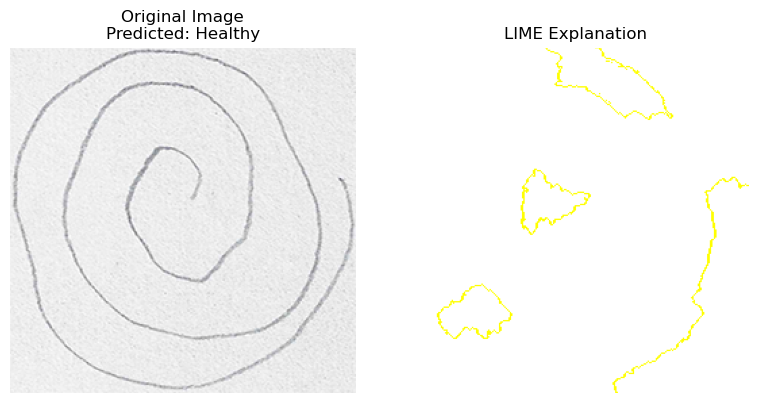

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 67.33it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].


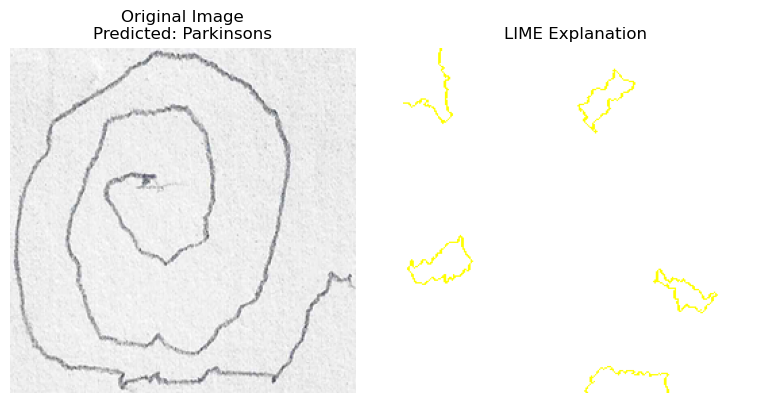

--- LIME Explanations for Wave Drawings (Random Forest Model) ---


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.56it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].


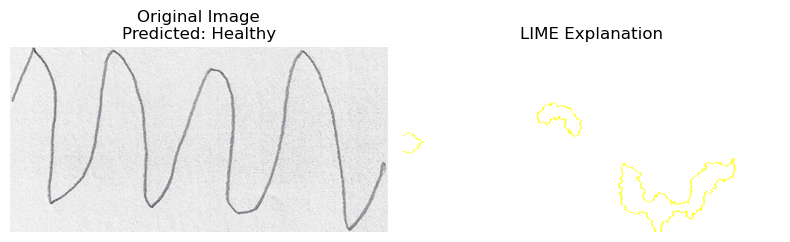

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 62.36it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].


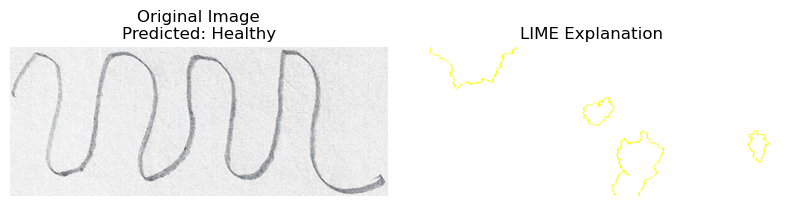

In [22]:
def explain_prediction_lime(model, image_path):
    # LIME requires a function that takes numpy arrays (images)
    # and returns prediction probabilities
    def prediction_fn(images):
        preprocessed_images = []
        for img in images:
            # Preprocess the image in the same way as the training data
            img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img_resized = cv2.resize(img_gray, (200, 200))
            _, img_threshold = cv2.threshold(img_resized, 0, 255,
                                           cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
            features = quantify_image(img_threshold)
            preprocessed_images.append(features)

        # Return prediction probabilities for both classes
        return model.predict_proba(np.array(preprocessed_images))

    # Read and prepare the image to be explained
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # LIME expects RGB

    # Create a LIME explainer
    explainer = lime_image.LimeImageExplainer()

    # Generate the explanation
    # We explain the top-predicted class
    explanation = explainer.explain_instance(image,
                                             prediction_fn,
                                             top_labels=1,
                                             hide_color=0,
                                             num_samples=1000)

    # Get the image and mask for the explanation
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=True,
                                                num_features=5,
                                                hide_rest=False)

    # Get the predicted label
    pred_label_index = model.predict_proba(np.array([quantify_image(cv2.threshold(cv2.resize(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), (200, 200)), 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1])]))[0].argmax()
    pred_label = "Parkinsons" if pred_label_index == 1 else "Healthy"

    # Display the original image and the explanation
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(image)
    ax1.set_title(f'Original Image\nPredicted: {pred_label}')
    ax1.axis('off')

    ax2.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    ax2.set_title("LIME Explanation")
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

# --- Now let's use the function ---

# Get a few random test images
testingPathSpiral = "Dataset/spiral/testing"
testingPathWave = "Dataset/wave/testing"
spiral_test_images = list(paths.list_images(testingPathSpiral))
wave_test_images = list(paths.list_images(testingPathWave))

print("--- LIME Explanations for Spiral Drawings (Random Forest Model) ---")
for i in range(2):
    image_path = random.choice(spiral_test_images)
    explain_prediction_lime(spiralModels['Rf']['classifier'], image_path)

print("--- LIME Explanations for Wave Drawings (Random Forest Model) ---")
for i in range(2):
    image_path = random.choice(wave_test_images)
    explain_prediction_lime(waveModels['Rf']['classifier'], image_path)


--- LIME Explanations for Spiral Drawings (XGBoost Model) ---


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.20it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].


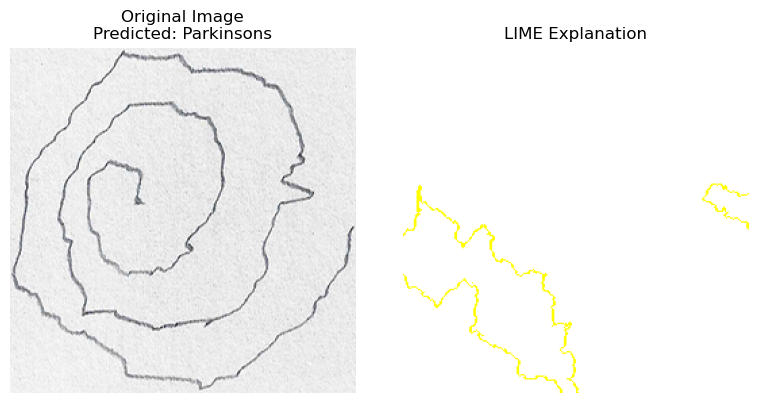

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.40it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].


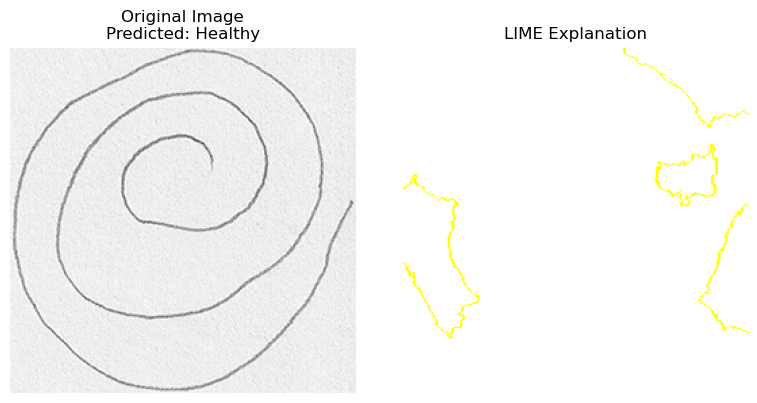


--- LIME Explanations for Wave Drawings (XGBoost Model) ---


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 73.61it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].


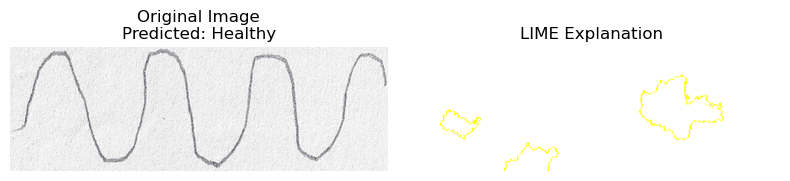

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 41.57it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].


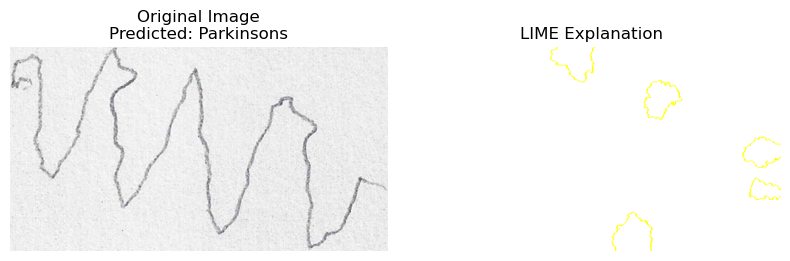

In [23]:
print("\n--- LIME Explanations for Spiral Drawings (XGBoost Model) ---")
for i in range(2):
    image_path = random.choice(spiral_test_images)
    explain_prediction_lime(spiralModels['Xgb']['classifier'], image_path)

print("\n--- LIME Explanations for Wave Drawings (XGBoost Model) ---")
for i in range(2):
    image_path = random.choice(wave_test_images)
    explain_prediction_lime(waveModels['Xgb']['classifier'], image_path)